In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题



In [8]:
data = pd.read_csv('votes.csv')

In [9]:
data.head()

,work_id,name,total,rank,fetch_time
0,6,沧蝶泪,26990,1,2024-11-19 14:04
1,17,见南山,15628,2,2024-11-19 14:04
2,49,云华九歌,12868,3,2024-11-19 14:04
3,41,小龙铃,12289,4,2024-11-19 14:04
4,47,余梦,10953,5,2024-11-19 14:04


In [10]:
data['fetch_time'] = pd.to_datetime(data['fetch_time'])
latest_time = data['fetch_time'].max()
latest = data[data['fetch_time'] == latest_time]
ranks = latest[latest['rank'] <= 5]
ids = ranks['work_id'].tolist()

In [11]:
data_filtered = data[data['work_id'].isin(ids)]
data_filtered['currank'] = data_filtered['work_id'].map(ranks.set_index('work_id')['rank'])
data_filtered['name_rank'] = data_filtered['name'] + '(当前第' + data_filtered['currank'].astype(str) + '名)'
data_filtered['name_rank'].unique()

C:\Users\yilin\AppData\Local\Temp\ipykernel_179980\2617970534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['currank'] = data_filtered['work_id'].map(ranks.set_index('work_id')['rank'])
C:\Users\yilin\AppData\Local\Temp\ipykernel_179980\2617970534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['name_rank'] = data_filtered['name'] + '(当前第' + data_filtered['currank'].astype(str) + '名)'


array(['沧蝶泪(当前第1名)', '见南山(当前第2名)', '云华九歌(当前第4名)', '小龙铃(当前第3名)',
       '余梦(当前第5名)'], dtype=object)

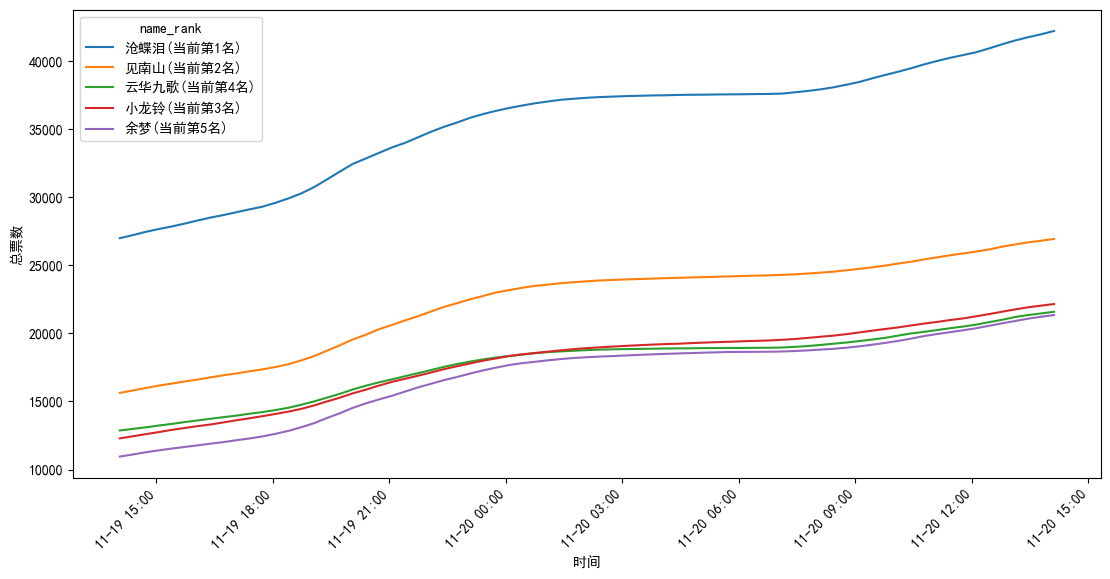

In [12]:
sns.lineplot(data=data_filtered, x='fetch_time', y='total', hue='name_rank')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylabel('总票数')
plt.xlabel('时间')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d %H:%M'))
plt.gcf().set_size_inches(12, 6)
plt.show()